# Starter notebook
---

## Example: Quadratic-band wall penalty with visualization

### Quadratic Band (Soft Wall)

$$
\phi(d) =
\begin{cases}
\frac{1}{2}(R - d)^2, & d \le R, \\
0, & d > R.
\end{cases}
$$
#### Behavior:
  - Smooth gradients
  - Creates a "buffer zone" around walls


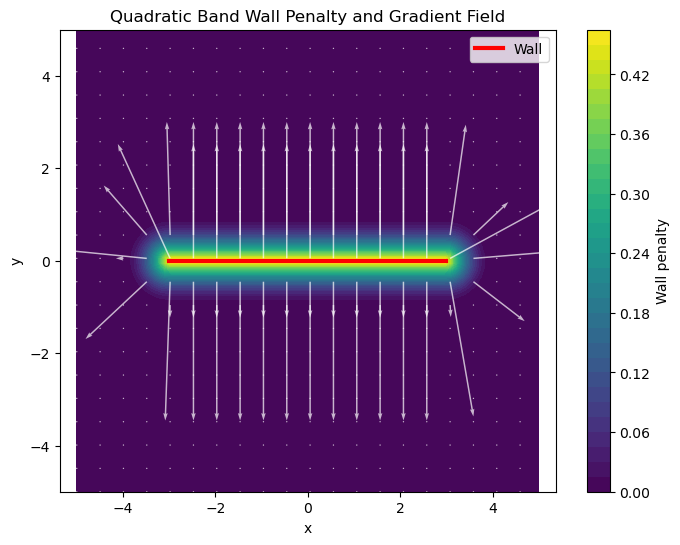

In [1]:
# Example: Quadratic-band wall penalty with visualization

import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Geometry: distance to segment
# -------------------------------
def point_to_segment_distance(x, a, b):
    """
    Distance from point x to line segment [a, b]
    """
    v = b - a
    w = x - a
    vv = np.dot(v, v)

    if vv == 0.0:
        return np.linalg.norm(x - a)

    t = np.dot(w, v) / vv
    t = np.clip(t, 0.0, 1.0)
    q = a + t * v
    return np.linalg.norm(x - q)

# -------------------------------
# Wall penalty (quadratic band)
# -------------------------------
def wall_penalty(x, a, b, R):
    d = point_to_segment_distance(x, a, b)
    if d <= R:
        return 0.5 * (R - d)**2
    else:
        return 0.0

# -------------------------------
# Grid setup
# -------------------------------
xmin, xmax = -5, 5
ymin, ymax = -5, 5
N = 100

xs = np.linspace(xmin, xmax, N)
ys = np.linspace(ymin, ymax, N)
X, Y = np.meshgrid(xs, ys)

# Wall definition (horizontal wall)
a = np.array([-3.0, 0.0])
b = np.array([ 3.0, 0.0])
R = 1.0  # influence radius

# -------------------------------
# Evaluate cost field
# -------------------------------
C = np.zeros_like(X)

for i in range(N):
    for j in range(N):
        x = np.array([X[i, j], Y[i, j]])
        C[i, j] = wall_penalty(x, a, b, R)

# -------------------------------
# Numerical gradient
# -------------------------------
dCy, dCx = np.gradient(C, ys, xs)

# -------------------------------
# Plot
# -------------------------------
plt.figure(figsize=(8, 6))

# Cost contours
plt.contourf(X, Y, C, levels=30, cmap="viridis")
plt.colorbar(label="Wall penalty")

# Negative gradient (descent direction)
plt.quiver(
    X[::5, ::5], Y[::5, ::5],
    -dCx[::5, ::5], -dCy[::5, ::5],
    color="white", alpha=0.7
)

# Wall segment
plt.plot([a[0], b[0]], [a[1], b[1]], "r-", linewidth=3, label="Wall")

plt.xlabel("x")
plt.ylabel("y")
plt.title("Quadratic Band Wall Penalty and Gradient Field")
plt.axis("equal")
plt.legend()
plt.show()


## Floor plans to use

Plot floor-plan

In [2]:
def plot_floor_plan(walls, start=None, goal=None):
    plt.figure(figsize=(6, 6))
    for a, b in walls:
        a = np.array(a)
        b = np.array(b)
        plt.plot([a[0], b[0]], [a[1], b[1]], "k-", linewidth=2)

    if start is not None:
        plt.plot(start[0], start[1], "go", markersize=8, label="Start")

    if goal is not None:
        plt.plot(goal[0], goal[1], "ro", markersize=8, label="Goal")

    plt.axis("equal")
    plt.grid(True)
    plt.legend()
    plt.title("Assignment Floor Plan")
    plt.show()


### Selectable Floor Plan Layouts

In [3]:
# -----------------------------------------------------------------------------
# Floor plan options for the assignment
# -----------------------------------------------------------------------------

import numpy as np

def load_floor_plan(name="baseline"):
    """
    Load a predefined floor plan.

    Available options:
      - "baseline"  : corridor + corner (recommended default)
      - "zigzag"    : narrow zig-zag corridor (oscillation test)
      - "deadend"   : dead-end with escape (local minimum trap)
      - "symmetric" : symmetric obstacle trap (pathological case)

    Returns:
      walls : list of (a, b) line segments
      start : np.array shape (2,)
      goal  : np.array shape (2,)
    """

    if name == "baseline":
        walls = [
            # Outer boundary
            ([-5, -5], [ 5, -5]),
            ([ 5, -5], [ 5,  5]),
            ([ 5,  5], [-5,  5]),
            ([-5,  5], [-5, -5]),

            # Interior corridor
            ([-1, -5], [-1,  2]),
            ([-1,  2], [ 3,  2]),
            ([ 3,  2], [ 3, -2]),
        ]
        start = [-4.0, -4.0]
        goal  = [ 4.0,  4.0]

    elif name == "zigzag":
        walls = [
            # Outer boundary
            ([-6, -4], [ 6, -4]),
            ([ 6, -4], [ 6,  4]),
            ([ 6,  4], [-6,  4]),
            ([-6,  4], [-6, -4]),

            # Zig-zag corridor
            ([-4, -3], [-1, -3]),
            ([-1, -3], [-1,  0]),
            ([-1,  0], [ 2,  0]),
            ([ 2,  0], [ 2,  3]),
            ([ 2,  3], [ 5,  3]),
        ]
        start = [-5.0, -3.5]
        goal  = [ 5.0,  3.5]

    elif name == "deadend":
        walls = [
            # Outer boundary
            ([-6, -6], [ 6, -6]),
            ([ 6, -6], [ 6,  6]),
            ([ 6,  6], [-6,  6]),
            ([-6,  6], [-6, -6]),

            # Dead-end chamber
            ([-2, -6], [-2,  2]),
            ([-2,  2], [ 2,  2]),
            ([ 2,  2], [ 2, -2]),
            ([ 2, -2], [-4, -2]),
            ([-4, -2], [-4,  4]),
        ]
        start = [ 0.0, -5.0]
        goal  = [ 5.0,  5.0]

    elif name == "symmetric":
        walls = [
            # Outer boundary
            ([-6, -6], [ 6, -6]),
            ([ 6, -6], [ 6,  6]),
            ([ 6,  6], [-6,  6]),
            ([-6,  6], [-6, -6]),

            # Symmetric obstacles
            ([-2, -2], [-2,  2]),
            ([ 2, -2], [ 2,  2]),
            ([-2,  2], [ 2,  2]),
        ]
        start = [ 0.0, -5.0]
        goal  = [ 0.0,  5.0]

    else:
        raise ValueError(f"Unknown floor plan: {name}")

    # Convert to NumPy arrays
    walls = [(np.array(a, dtype=float), np.array(b, dtype=float)) for a, b in walls]
    start = np.array(start, dtype=float)
    goal  = np.array(goal, dtype=float)

    return walls, start, goal


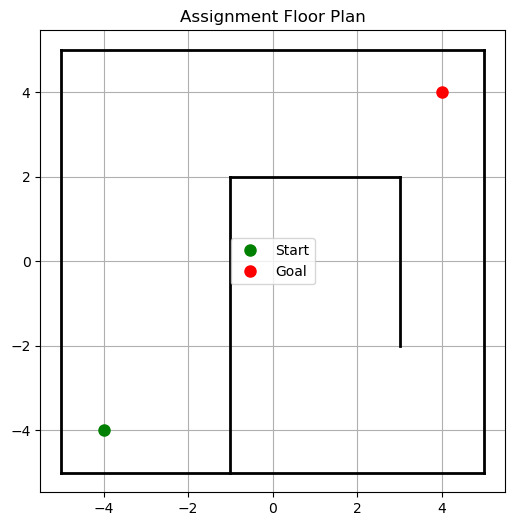

In [7]:
#@title Floor Plan Selection

floor_plan = "baseline" #@param ["baseline", "zigzag", "deadend", "symmetric"]


walls, start, goal = load_floor_plan(floor_plan)

plot_floor_plan(walls, start, goal)
